#Exercise 3.1: Convergence of sequences:#

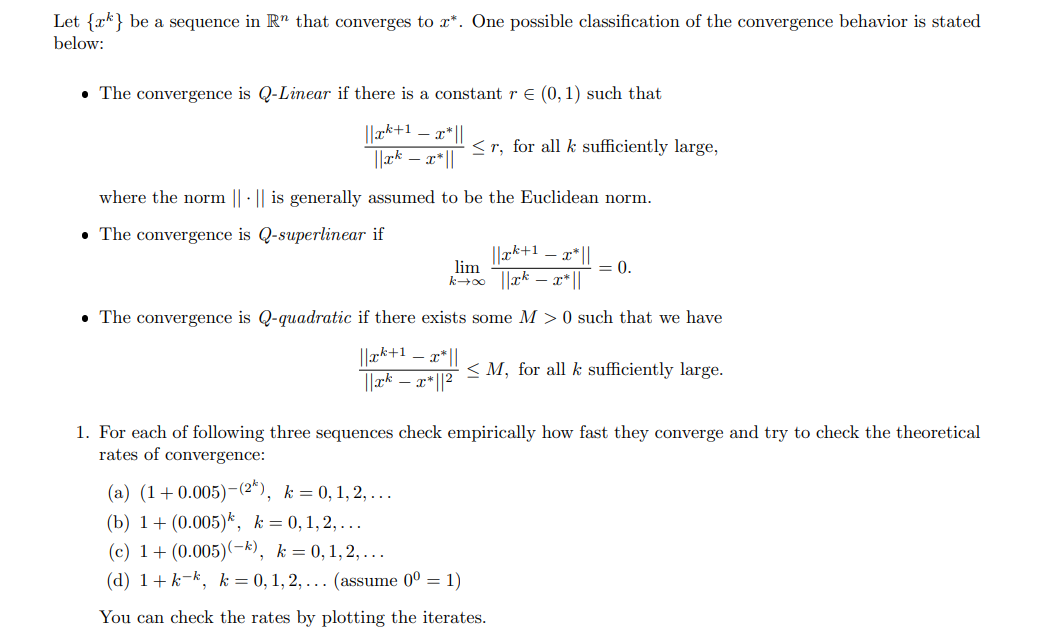

#Exercise 3.2: Data Preparation Exercise (PREP)#

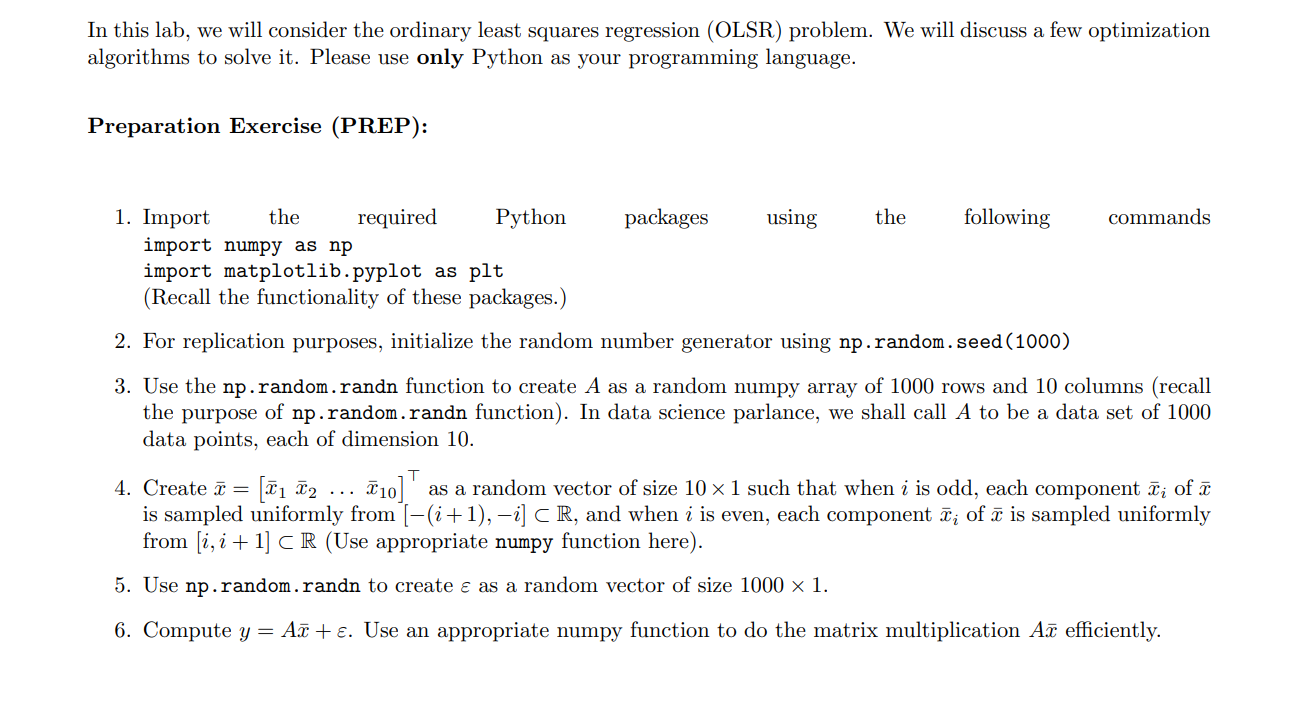

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1000)
A = np.random.randn(1000,10)
print(A.shape)
x_bar = []
for i in range(1,11):
  if i%2==0:
    x_bar.append([np.random.uniform(-(i+1),-i)])
  else:
    x_bar.append([np.append(i,i+1)])
x_bar=np.array([x_bar])
print(x_bar.shape)
e = np.random.randn(1000,1)
print(e.shape)
y = np.matmul(A,x_bar) + e

(1000, 10)
(1, 10, 1)
(1000, 1)


<ipython-input-1-4b7287c5946d>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_bar=np.array([x_bar])


In [2]:
import math
from timeit import default_timer as timer
np.random.seed(1000)

In [3]:
def create_data():
    np.random.seed(1000)

    A = np.random.randn(1000, 10)
    x_bar = np.zeros(10)
    for i in range(10):
      if (i+1)%2 == 0:
        x_bar[i] = np.random.uniform(low = i+1, high = i+2)
      else:
        x_bar[i] = np.random.uniform(low = -(i+2), high = -(i+1) )
      x_bar = np.array(x_bar)
      x_bar = x_bar.reshape(10,1)
    epsilon = np.random.randn(1000, 1)
    y = np.add(np.dot(A, x_bar), epsilon)

    return A, x_bar, y

In [4]:
def evalf(A, x, y):
    temp = np.subtract(np.dot(A,x),y)
    fval = 0.5*np.linalg.norm(temp,2)**2
    return fval

In [5]:
A,_,y = create_data()
x = []
for i in range(10):
  x.append([1])
x = np.array(x)

In [6]:
def evalg(A, x, y):
    temp = np.dot(A,x) - y
    grad = np.dot(A.T,temp)
    return grad

In [7]:
def evalh(A, x):
    hess = np.matmul(A.T, A)
    return hess

In [8]:
def compute_D_k_newton(A, x):
    d = np.linalg.inv(evalh(A, x))
    return d
def compute_steplength_backtracking_scaled_direction(A, x, y, gradf, D_k, alpha_start, rho, gamma): #add appropriate arguments to the function
    alpha = alpha_start
    p_k = -np.dot(D_k,gradf)
    while evalf(A, np.add(x,np.multiply(alpha,p_k)),y) > np.multiply(gamma*alpha,np.dot(gradf.T,p_k)) + evalf(A,x,y):
        alpha = rho*alpha
    return alpha

In [9]:
CONSTANT_STEP_LENGTH = 3
BACKTRACKING_LINE_SEARCH = 2
EXACT_LINE_SEARCH = 1

In [10]:
def find_minimizer_Newtonmethod(start_x, A, y, tol, line_search_type, *args):
    x = start_x
    g_x = evalg(A, x, y)

    x_array = [x]
    f_array = [evalf(A, x,y)]
    if line_search_type == BACKTRACKING_LINE_SEARCH:
        if args is None:
            err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive any args. Please check!'
            raise ValueError(err_msg)
        elif len(args)<3 :
            err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive three args. Please check!'
            raise ValueError(err_msg)
        else:
            alpha_start = float(args[0])
            rho = float(args[1])
            gamma = float(args[2])
    k = 0

    while (np.linalg.norm(g_x) > tol):
        d_k = compute_D_k_newton(A, x)
        if line_search_type == BACKTRACKING_LINE_SEARCH:
            step_length = compute_steplength_backtracking_scaled_direction(A, x, y, g_x, d_k, alpha_start, rho, gamma)
        elif line_search_type == CONSTANT_STEP_LENGTH:
            step_length = 1.0
        else:
            raise ValueError('Line search type unknown. Please check!')

        x = np.subtract(x, np.multiply(step_length,np.dot(d_k, g_x)))
        k += 1
        g_x = evalg(A, x, y)
        x_array.append(x)
        f_array.append(evalf(A, x,y))

    return x_array, f_array, k

In [11]:
def find_minimizer_BFGS(start_x, A, y, tol, line_search_type, *args):
    x = start_x
    g_x = evalg(A, x, y)

    if line_search_type == BACKTRACKING_LINE_SEARCH:
        if args is None:
            err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive any args. Please check!'
            raise ValueError(err_msg)
        elif len(args)<3 :
            err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive three args. Please check!'
            raise ValueError(err_msg)
        else:
            alpha_start = float(args[0])
            rho = float(args[1])
            gamma = float(args[2])
    k = 0
    B = np.identity(10)
    x_array = [x]
    f_array = [evalf(A, x,y)]

    while (np.linalg.norm(g_x) > tol):
        p = -np.dot(B, g_x)
        if line_search_type == BACKTRACKING_LINE_SEARCH:
            d_k = B
            step_length = compute_steplength_backtracking_scaled_direction(A, x, y, g_x, d_k, alpha_start, rho, gamma)
        elif line_search_type == CONSTANT_STEP_LENGTH:
            step_length = 1.0
        else:
            raise ValueError('Line search type unknown. Please check!')

        x_next = np.add(x, np.multiply(step_length,p))
        s_k = x_next - x
        y_k = evalg(A, x_next,y) - g_x
        mu_k = 1.0/np.dot(y_k.T, s_k)
        temp = (np.identity(10) - np.multiply(mu_k,np.outer(y_k, s_k.T)))
        B = np.dot(temp.T, np.dot(B, temp)) + np.multiply(mu_k, np.outer(s_k, s_k.T))
        k += 1
        x = x_next
        g_x = evalg(A, x, y)

        x_array.append(x)
        f_array.append(evalf(A, x, y))

    return x_array, f_array, k

In [12]:
A, x_bar, y = create_data()
my_start_x = []
for i in range(10):
  my_start_x.append([0])
my_start_x=np.array(my_start_x)


Results obtained from Newton method (with backtracking)
Minimizer: [[-1.04982253]
 [ 2.95189743]
 [-3.34298192]
 [ 4.60956007]
 [-5.71176195]
 [ 6.89877618]
 [-7.62879358]
 [ 8.16821112]
 [-9.22221199]
 [10.05669293]],
Final Objective function value: 505.647329524551,
Iterations taken to terminate: 5


Actual x_bar: [[-1.06258705]
 [ 2.94307072]
 [-3.34150552]
 [ 4.58252615]
 [-5.75947573]
 [ 6.93512469]
 [-7.61893094]
 [ 8.16818187]
 [-9.2179964 ]
 [10.00022174]]

Time taken to find minimizer by Newton's method: 0.024201742999991893



<ipython-input-13-64c66707bdf8>:19: RuntimeWarning: divide by zero encountered in log
  plot_x.append(np.log(np.linalg.norm(x_array_newton[i] - x_opt)))


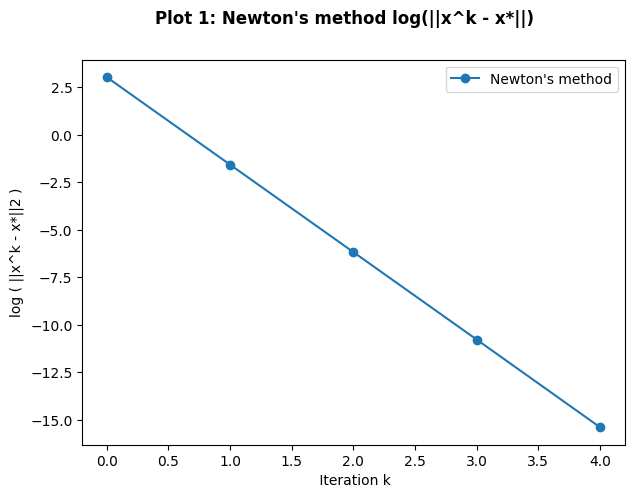

In [13]:
my_tol= 1e-5
alpha_start = 0.99
rho = 0.5
gamma = 0.5
start_time = timer()
x_array_newton, f_array_newton, iters_opt_newton = find_minimizer_Newtonmethod(my_start_x, A, y, my_tol, BACKTRACKING_LINE_SEARCH, alpha_start, rho, gamma)
end_time = timer()
times_newton = end_time - start_time
print(f"\nResults obtained from Newton method (with backtracking)\nMinimizer: {x_array_newton[-1]},\nFinal Objective function value: {f_array_newton[-1]},\nIterations taken to terminate: {iters_opt_newton}\n")
print('')
print(f'Actual x_bar: {x_bar}\n')
print(f"Time taken to find minimizer by Newton's method: {times_newton}")
print('')


x_opt = x_array_newton[-1]
plot_x = []
for i in range(len(x_array_newton)):
    plot_x.append(np.log(np.linalg.norm(x_array_newton[i] - x_opt)))

fig, ax = plt.subplots(1,1, figsize = (7,5))
fig.suptitle("Plot 1: Newton's method log(||x^k - x*||)", fontweight= 'bold')
ax.plot(np.arange(len(x_array_newton)), plot_x, 'o-', label = "Newton's method")
ax.set_xlabel(" Iteration k")
ax.set_ylabel("log ( ||x^k - x*||2 )")
ax.legend()

<ipython-input-14-f45683fc8e8d>:4: RuntimeWarning: divide by zero encountered in log
  plot_fx.append(np.log(np.abs(f_array_newton[i] - f_opt)))


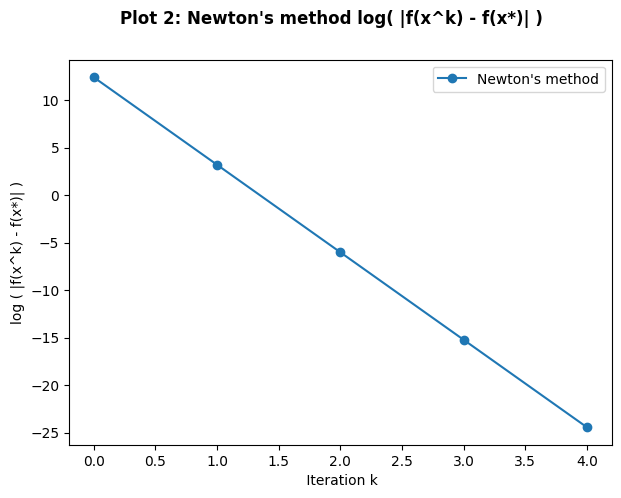

In [14]:
f_opt = f_array_newton[-1]
plot_fx = []
for i in range(len(f_array_newton)):
    plot_fx.append(np.log(np.abs(f_array_newton[i] - f_opt)))

fig2, ax = plt.subplots(1,1, figsize = (7,5))
fig2.suptitle("Plot 2: Newton's method log( |f(x^k) - f(x*)| )", fontweight= 'bold')
ax.plot(np.arange(len(f_array_newton)), plot_fx, 'o-', label = "Newton's method")
ax.set_xlabel(" Iteration k")
ax.set_ylabel("log ( |f(x^k) - f(x*)| )")
ax.legend()

Newton's Method with backtracking line search

α=0.99,ρ=0.5,γ=0.5

Upon completing our algorithm, let x∗ represent the final optimal solution:

The values of x∗ are as follows:
x∗ = [[-1.04982253]
 [ 2.95189743]
 [-3.34298192]
 [ 4.60956007]
 [-5.71176195]
 [ 6.89877618]
 [-7.62879358]
 [ 8.16821112]
 [-9.22221199]
 [10.05669293]]

Additionally, we have x¯ as:
x¯ = [[-1.06258705]
 [ 2.94307072]
 [-3.34150552]
 [ 4.58252615]
 [-5.75947573]
 [ 6.93512469]
 [-7.61893094]
 [ 8.16818187]
 [-9.2179964 ]
 [10.00022174]]

We observe that:
- Both x∗ and x¯ exhibit nearly identical values, within the tolerance precision.
- The respective function values for x∗ and x¯, denoted as f(x∗) and f(x¯), are approximately the same, demonstrating consistency with the tolerance precision.

The convergence rate remains constant and exhibits quadratic convergence for both the iterates and the objective function values. Initially, rapid convergence is observed, followed by a gradual convergence phase.



Results obtained from BFGS method (with backtracking)
Minimizer: [[-1.04982253]
 [ 2.95189743]
 [-3.34298192]
 [ 4.60956007]
 [-5.71176195]
 [ 6.89877618]
 [-7.62879358]
 [ 8.16821111]
 [-9.22221199]
 [10.05669293]],
Final Objective function value: 505.64732952455125,
Iterations taken to terminate: 18


Actual x_bar: [[-1.06258705]
 [ 2.94307072]
 [-3.34150552]
 [ 4.58252615]
 [-5.75947573]
 [ 6.93512469]
 [-7.61893094]
 [ 8.16818187]
 [-9.2179964 ]
 [10.00022174]]

Time taken to find minimizer by BFGS method: 0.06921598600001744



<ipython-input-15-cea6393c2edf>:22: RuntimeWarning: divide by zero encountered in log
  plot_x_bfgs.append(np.log(np.linalg.norm(x_array_bfgs[i] - x_opt)))


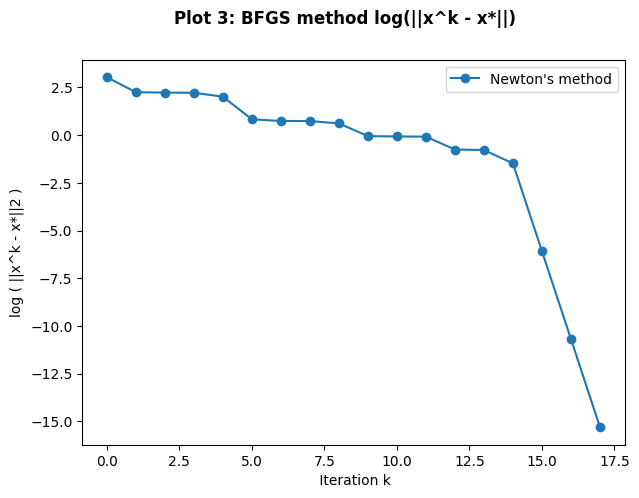

In [15]:
my_start_x = []
for i in range(10):
  my_start_x.append([0])
my_start_x=np.array(my_start_x)
my_tol= 1e-5
alpha_start = 0.99
rho = 0.5
gamma = 0.5
start_time = timer()
x_array_bfgs, f_array_bfgs, iters_opt_bfgs = find_minimizer_BFGS(my_start_x, A, y, my_tol, BACKTRACKING_LINE_SEARCH, alpha_start, rho, gamma)
end_time = timer()
time_bfgs = end_time - start_time
print(f"\nResults obtained from BFGS method (with backtracking)\nMinimizer: {x_array_bfgs[-1]},\nFinal Objective function value: {f_array_bfgs[-1]},\nIterations taken to terminate: {iters_opt_bfgs}\n")
print('')
print(f'Actual x_bar: {x_bar}\n')
print(f"Time taken to find minimizer by BFGS method: {time_bfgs}")
print('')

x_opt = x_array_bfgs[-1]
plot_x_bfgs = []
for i in range(len(x_array_bfgs)):
    plot_x_bfgs.append(np.log(np.linalg.norm(x_array_bfgs[i] - x_opt)))

fig, ax = plt.subplots(1,1, figsize = (7,5))
fig.suptitle("Plot 3: BFGS method log(||x^k - x*||)", fontweight= 'bold')
ax.plot(np.arange(len(x_array_bfgs)), plot_x_bfgs, 'o-', label = "Newton's method")
ax.set_xlabel(" Iteration k")
ax.set_ylabel("log ( ||x^k - x*||2 )")
ax.legend()

<ipython-input-16-1e2aaf00eb44>:4: RuntimeWarning: divide by zero encountered in log
  plot_fx_bfgs.append(np.log(np.abs(f_array_bfgs[i] - f_opt_bfgs)))


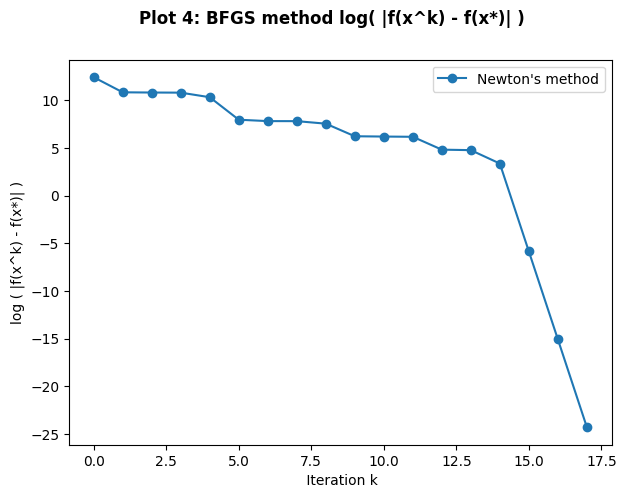

In [16]:
f_opt_bfgs = f_array_bfgs[-1]
plot_fx_bfgs = []
for i in range(len(f_array_bfgs)):
    plot_fx_bfgs.append(np.log(np.abs(f_array_bfgs[i] - f_opt_bfgs)))

fig2, ax = plt.subplots(1,1, figsize = (7,5))
fig2.suptitle("Plot 4: BFGS method log( |f(x^k) - f(x*)| )", fontweight= 'bold')
ax.plot(np.arange(len(f_array_bfgs)), plot_fx_bfgs, 'o-', label = "Newton's method")
ax.set_xlabel(" Iteration k")
ax.set_ylabel("log ( |f(x^k) - f(x*)| )")
ax.legend()

#Let x∗ be the final optimal solution provided by our algorithm.

The final optimal solution, denoted as x∗, is represented by the following values:
x∗ = [[-1.04982253]
[ 2.95189743]
[-3.34298192]
[ 4.60956007]
[-5.71176195]
[ 6.89877618]
[-7.62879358]
[ 8.16821111]
[-9.22221199]
[10.05669293]]

Similarly, we have x¯ with the following values:
x¯ = [[-1.06258705]
[ 2.94307072]
[-3.34150552]
[ 4.58252615]
[-5.75947573]
[ 6.93512469]
[-7.61893094]
[ 8.16818187]
[-9.2179964 ]
[10.00022174]]

Further analysis reveals:

Both x∗ and x¯ exhibit nearly identical values, meeting the tolerance precision criteria.
Evaluating the objective function at these points, we find:
f(x∗) = 505.64732952455125
f(x¯) = 505.64732952455125
Again, both function values align closely with the tolerance precision standards.
Additionally, the convergence behavior remains consistent:

The convergence rate is quadratic for both the iterates and the objective function values.
Initially, rapid convergence is observed, transitioning into a slower convergence phase over time.
It's noteworthy that for the initial iterations, slight perturbations are observed, but these are swiftly resolved as the convergence progresses.

# ans:
Both Newton's method and the BFGS method exhibited quadratic convergence. However, Newton's method required fewer iterations to converge compared to the BFGS method. This disparity is expected, considering that the BFGS method relies on an approximation of the Hessian matrix. Initially, the BFGS method exhibited slower convergence than Newton's method and involved some oscillations. Nonetheless, both methods ultimately converged to the same objective value and optimum.